<center>
<a href="http://www.insa-toulouse.fr/" ><img src="http://www.math.univ-toulouse.fr/~besse/Wikistat/Images/logo-insa.jpg" style="float:left; max-width: 120px; display: inline" alt="INSA"/></a> 

<a href="http://wikistat.fr/" ><img src="http://www.math.univ-toulouse.fr/~besse/Wikistat/Images/wikistat.jpg" style="max-width: 250px; display: inline"  alt="Wikistat"/></a>

<a href="http://www.math.univ-toulouse.fr/" ><img src="http://www.math.univ-toulouse.fr/~besse/Wikistat/Images/logo_imt.jpg" style="float:right; max-width: 250px; display: inline" alt="IMT"/> </a>
</center>

#  [*High Dimensional Statistics*](https://github.com/wikistat/HDStat) avec  <a href="https://cran.r-project.org/"><img src="https://cran.r-project.org/Rlogo.svg" style="max-width: 40px; display: inline" alt="R"/></a>

# Détection d'anomalies dans des données fonctionnelles 

**Résumé** Tutoriel de détection d'anomalies dans des données fonctionnelles. Les données simulées reproduisent les comportement de télémétries observées lors de tests réalisés sur des sattellites avant lancement. Ce sujet est issu du travail de thèse de Clémentine Barreyre chez Airbus Defense and Space. 


** Librairies **
La liste  des *packages* ou librairies que nous utiliserons : la librairie **`wavethress`** ou la librairie **`waveslim`** pour calculer les coefficients d'ondelettes et la librairie **`e1071`** sera utilisée pour la méthode  one-class SVM, et la librairie **`DMwR`** pour la méthode Local Outlier Factor.   


In [1]:
library(wavethresh)
library(waveslim)

library("e1071")
library(DMwR)

Loading required package: MASS
Warning message:
“package ‘MASS’ was built under R version 3.4.3”WaveThresh: R wavelet software, release 4.6.8, installed

Copyright Guy Nason and others 1993-2016

Note: nlevels has been renamed to nlevelsWT


waveslim: Wavelet Method for 1/2/3D Signals (version = 1.7.5)

Loading required package: lattice
Loading required package: grid


## 1  Description et lecture des données

On dispose de 480 jours de télémesures. Chaque jour comporte 256 mesures  à intervalles de temps réguliers. Le jeu de données comporte le vecteur des temps et le vecteur des valeurs de la télémesure aux différents instants.

Nous sommes dans un contexte d'apprentissage semi-supervisé : nous savons que les 240 derniers jours ne comportent pas d'anomalies. Les 240 premiers jours comportent quelques anomalies que nous allons chercher à détecter. 



### 1.1 Lecture des données  et statistiques élémentaires


In [2]:
TM=read.csv("TM_Saved_simulated_2017-06-23.dat", row.names=1)
summary(TM)
dim(TM)


     time.w             TM.w        
 Min.   :3.9e-03   Min.   :-2.6579  
 1st Qu.:1.2e+02   1st Qu.:-0.4008  
 Median :2.4e+02   Median : 0.1237  
 Mean   :2.4e+02   Mean   : 0.3221  
 3rd Qu.:3.6e+02   3rd Qu.: 0.7914  
 Max.   :4.8e+02   Max.   : 4.1644  

[1] 122880      2


Dans un premier temps, on se place donc dans un cadre non supervisé.  On n'utilise  pas l'information fournie par les  240 premières courbes qui ont été labellisées comme étant exemptes de toute anomalie.
On utilise seulement les 240 premières courbes, qui contiennent un petit nombre d'anomalies. 


In [3]:
p = 256

TM_480 = matrix(TM[,2], nrow = p)
dim(TM_480)

TM_240 = TM_480[,c(1:240)]

dim(TM_240)

[1] 256 480

[1] 256 240

On précise quelles sont les 8 courbes atypiques. Ceci est inconnu du statisticien et servira seulement pour la validation de nos résultats. 
On introduit des couleurs différentes selon le type d'anomalies :

- 4 anomalies de "forme " représentées en rouge : changement de forme ou d'amplitude des courbes 
- 3 anomalies locales représentées en rose : ajout d'un pic ou de bruit ou d'une valeur atypique
- 1 anomalie de périodicité (deux périodes au lieu d'une) représentée en orange.


In [4]:
anomalies = rep(0,240)
anomalies[c(134,201, 156, 26, 220, 6, 70, 98)] = 1
anomalies0 = rep(0,240)

color = rep(1, ncol(TM_240))
color[c(26,220,6,70)] = "red"
color[c(134,201,156)] = "pink3"
color[98] = "orange"                            



### 1.2 Tracés des courbes
#### Ensembe des courbes

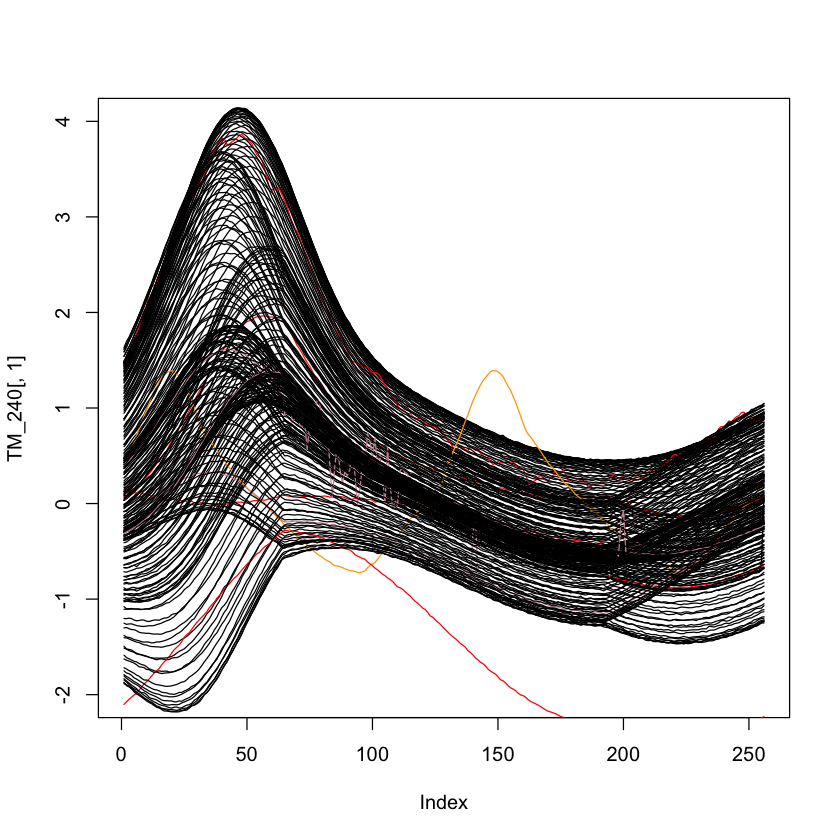

In [5]:
 plot(TM_240[,1],col=color[1],type='l',ylim=c(-2,4))
for (j in 2:240) {
    lines(TM_240[,j],col=color[j],type='l')}

#### Quelques courbes 

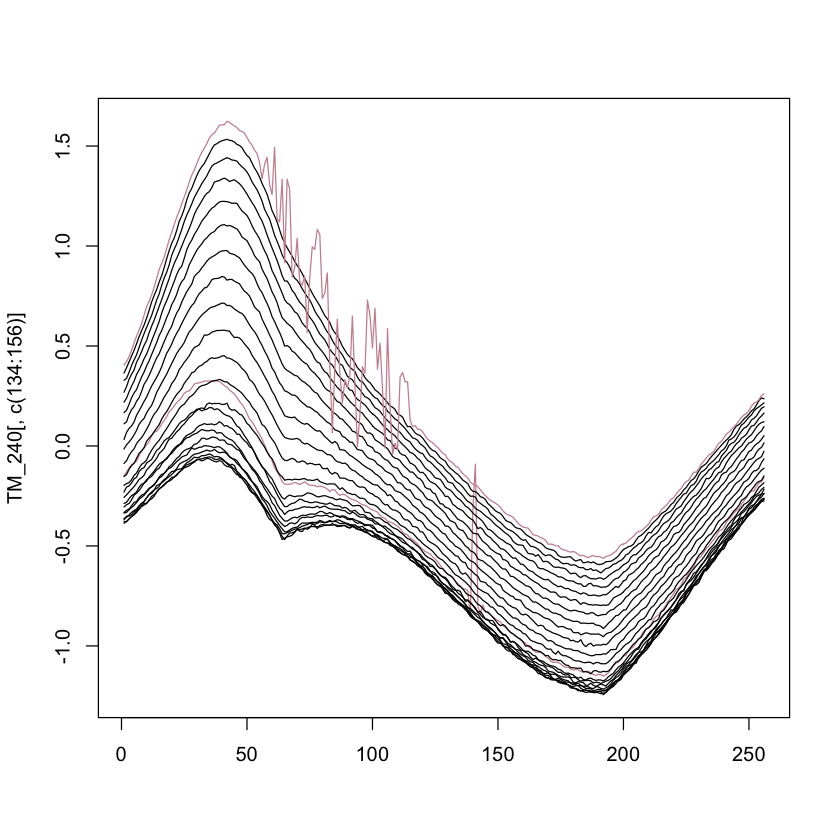

In [6]:
matplot(TM_240[,c(134:156)],type="l",col=color[c(134:156)],lty=1)

#### Ensemble des courbes atypiques

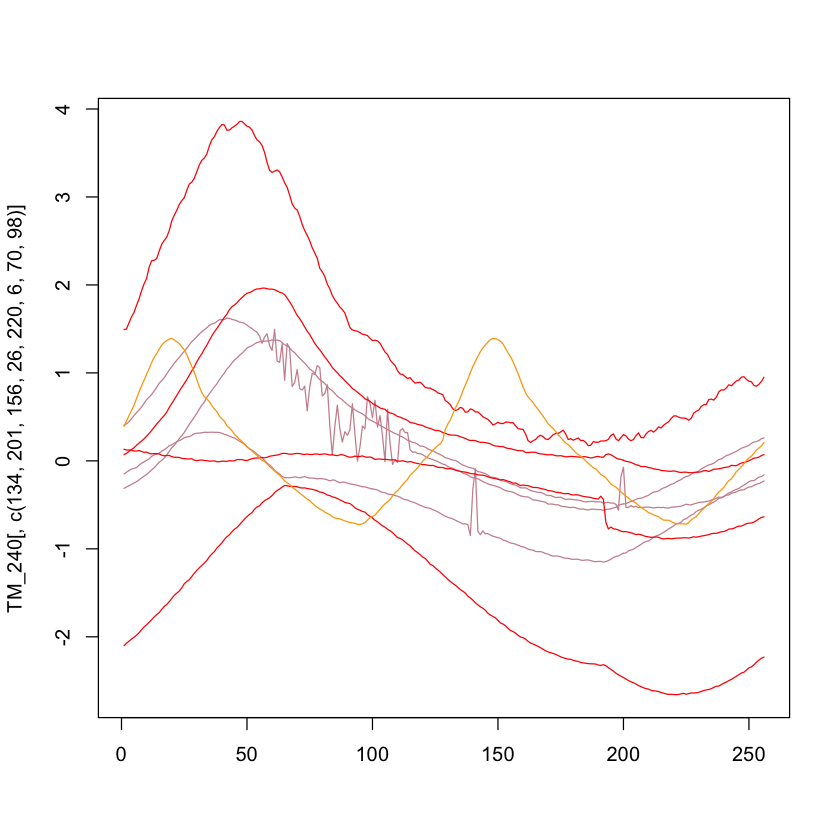

In [7]:
matplot(TM_240[,c(134,201, 156, 26, 220, 6, 70, 98)],type="l",col=color[c(134,201, 156, 26, 220, 6, 70, 98)],lty=1)

## 2. Analyse en composantes principales
### 2.1 Sur le jeu de données contenant des anomalies

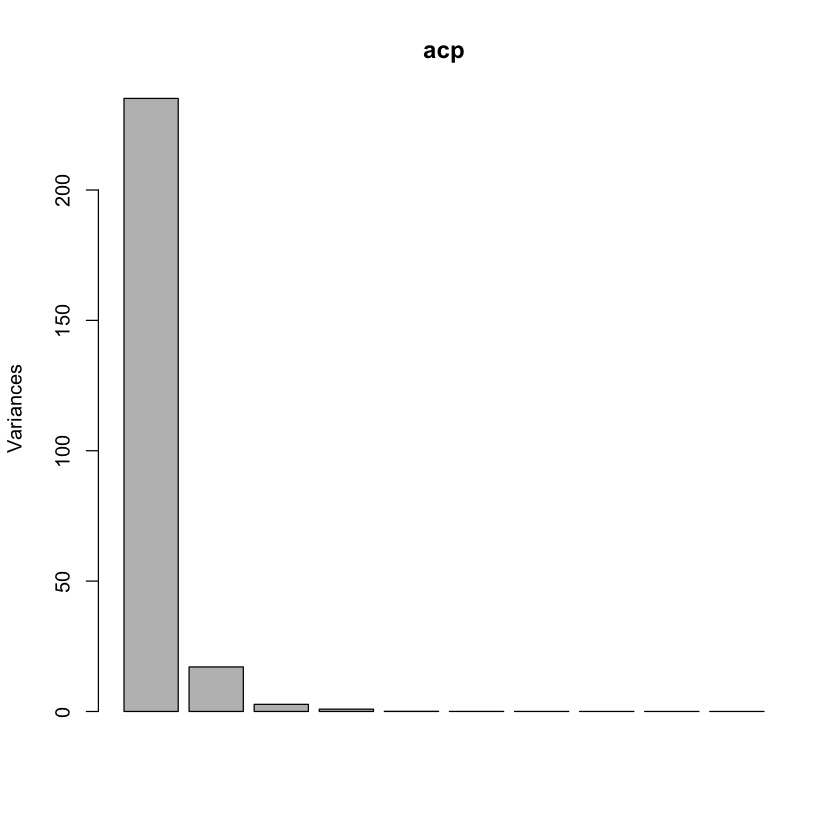

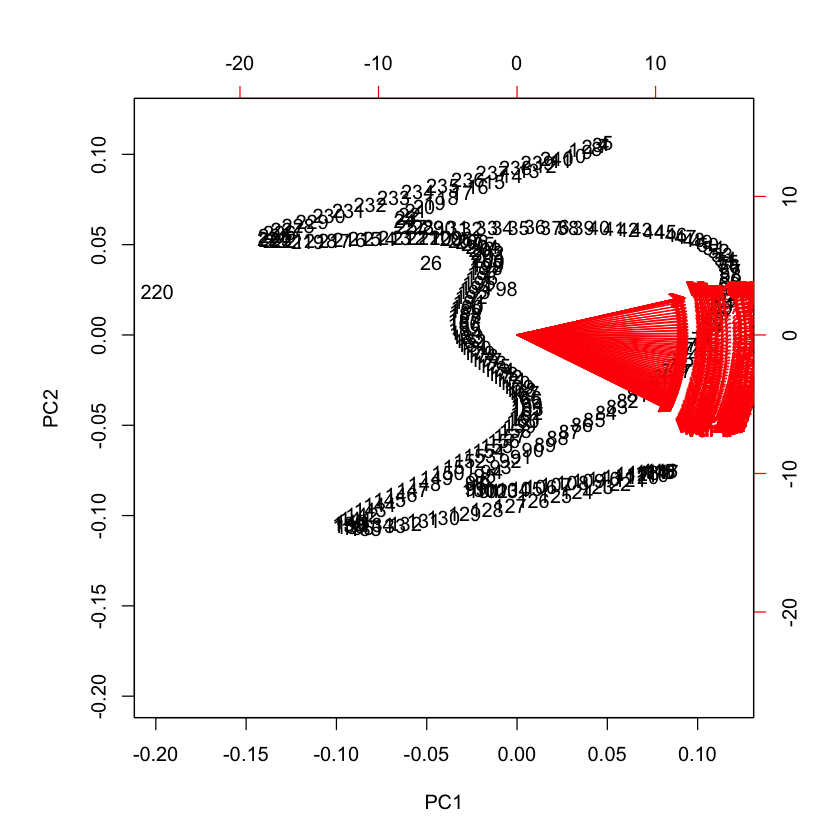

In [8]:
acp=prcomp(t(TM_240), scale=TRUE)
plot(acp)
biplot(acp)

### 2.2 Sur le jeu de données ne contenant pas d'anomalies: 

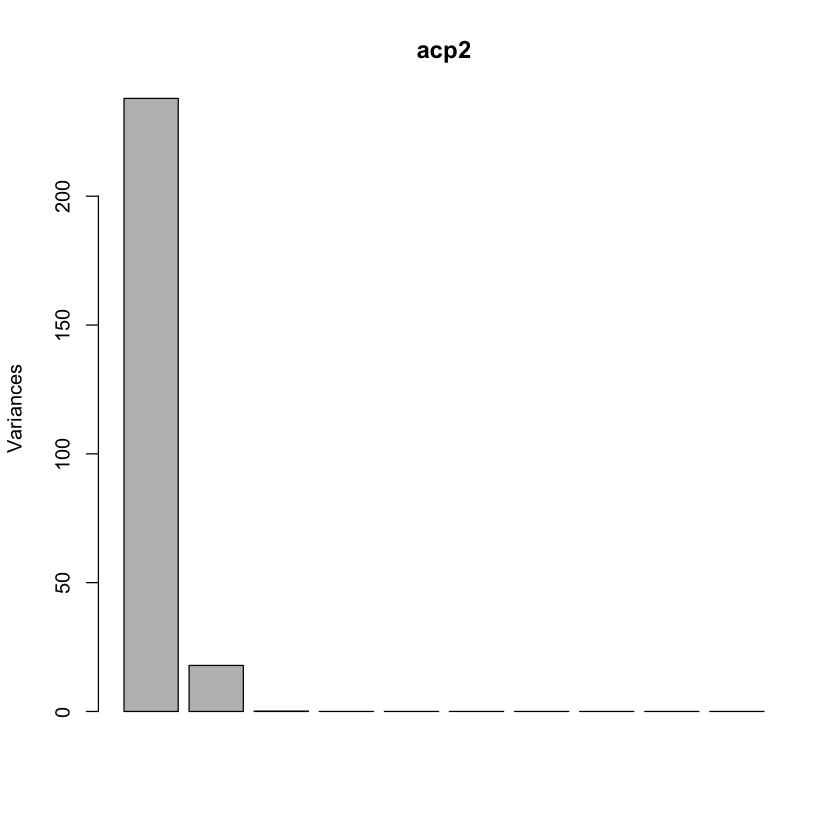

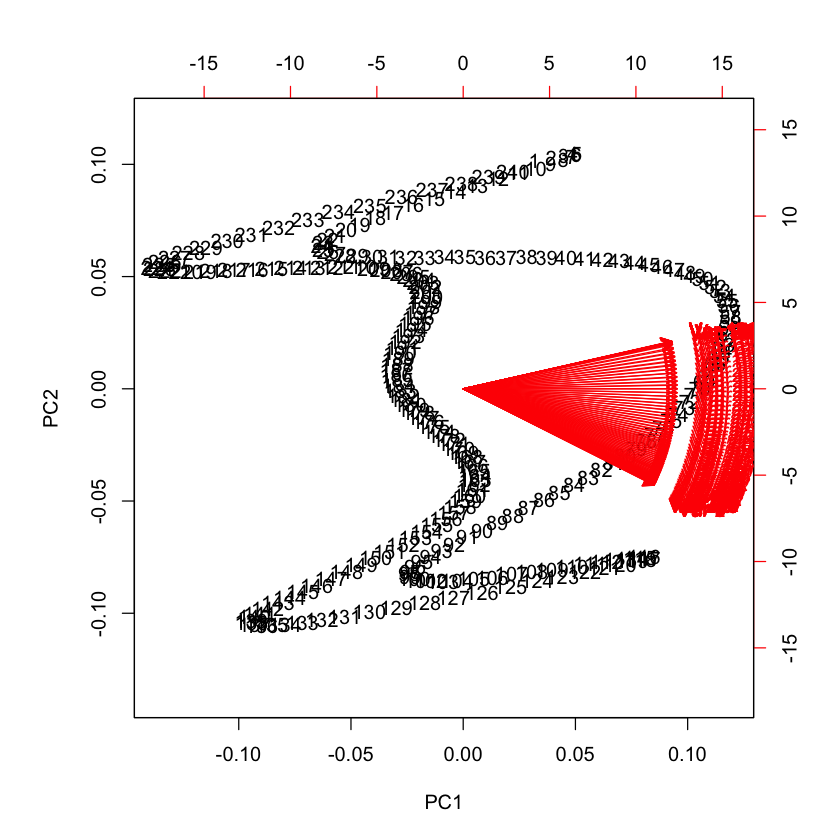

In [9]:
acp2=prcomp(t(TM_480[,c(241:480)]), scale=TRUE)
plot(acp2)
biplot(acp2)

## 3 Définition des *features* 

Pour détecter les anomalies, on peut utiliser les données brutes, mais ce n'est pas toujours le plus efficace. On peut aussi essayer d'extraire de nouvelles variables, appelées caractéristiques (*features*), qui permettront peut-être de mettre davantage en lumière les anomalies. Pour cela, on peut par exemple utiliser les coefficients de la projection des données brutes sur des bases orthonormées: base de composantes principales, ou bases d'ondelettes. 


### 3.1 Coefficients dans la base des composantes principales


In [10]:
# Calcul des Features obtenues à l'aide de l'ACP : 

ACP = prcomp(t(TM_240))
phi= ACP$rotation
Theta = t(TM_480)%*%phi

index = min(which(cumsum(ACP$sdev)/sum(ACP$sdev)>0.95))
index

[1] 10

In [11]:

# Definition des features utilisées pour détecter les anomalies : 

# Les coefficients pour les courbes ne contenant pas d'anomalies
set00 = Theta[241:480,1:index]

# Pour le jeu de données contenant des anomalies 
# données brutes
set0= t(TM_240)

# Coefficients sur la base des composantes principales
set1 = Theta[1:240,]

# Seulement les coefficients associés aux plus grandes variances
set2 = Theta[1:240,1:index]

### 3.2 Coefficients dans une base d'ondelettes

In [12]:
library(waveslim)

Train=t(TM_240)
nlevels =8 # 2**8=256

TrainT = NULL # table de coefficients d'ondelettes
threshTrainT = NULL # table de coefficients d'ondelettes seuillés

for (i in 1:nrow(Train)){ 
    xTrain = Train[i,]
    wtTrain = dwt(xTrain, n.levels=8)
    threshwtTrain=universal.thresh(wtTrain, max.level = 4, hard = TRUE)
    TrainT = rbind(TrainT,unlist(wtTrain))
    threshTrainT =rbind(threshTrainT ,unlist(threshwtTrain))
    }

TrainT=data.frame(TrainT)
threshTrainT=data.frame(threshTrainT)

dim(TrainT)
dim(threshTrainT)

# Nombre de coefficients non nuls : 

sum(sum(TrainT!=0))
sum(sum(threshTrainT!=0))

[1] 240 256

[1] 240 256

[1] 61440

[1] 9529

In [13]:
# Definition des features utilisées pour détecter les anomalies : 

# Tous les coefficients sur la base d'ondelettes :
set3= TrainT

# Seulement les coefficients d'ondelettes de niveau le plus fin J=7 
set4= TrainT[,1:128]

# Les coefficients des niveaux J=0 à  6
set5=TrainT[, 128:256]

# Les coefficients seuillés : 
set6=threshTrainT

### 3.3 Analyse en composantes principales sur les coefficients d'ondelettes

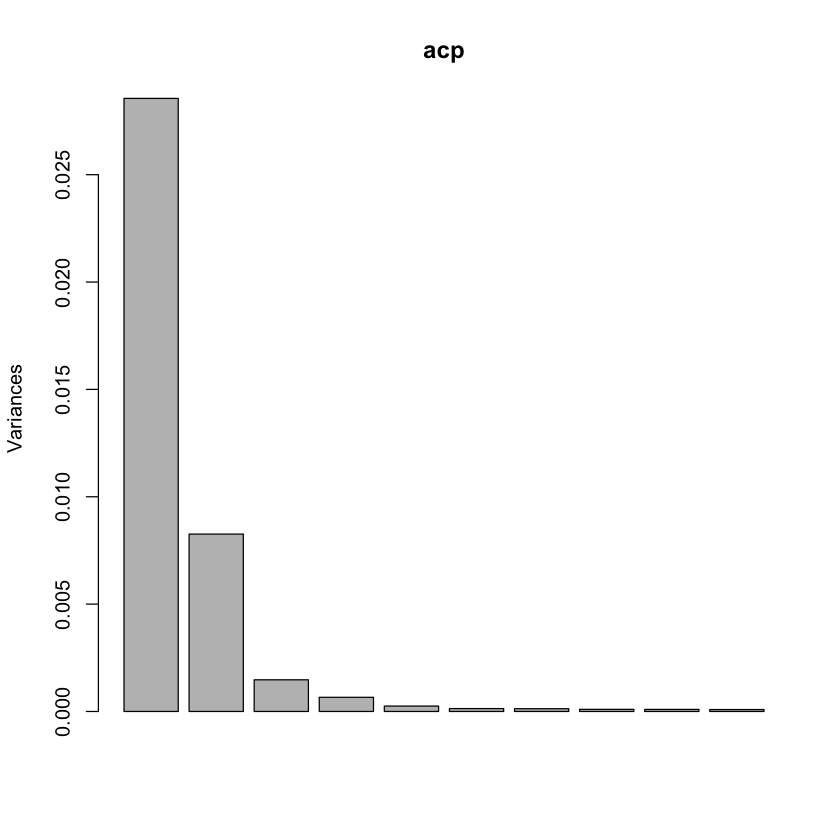

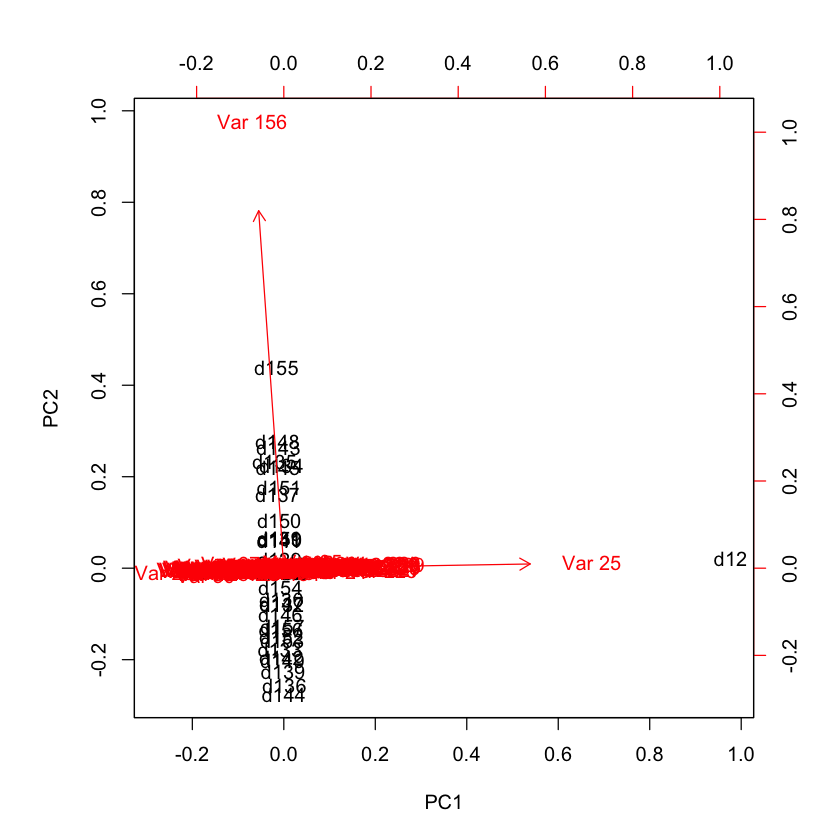

In [14]:
acp=prcomp(t(set4))
plot(acp)
biplot(acp)

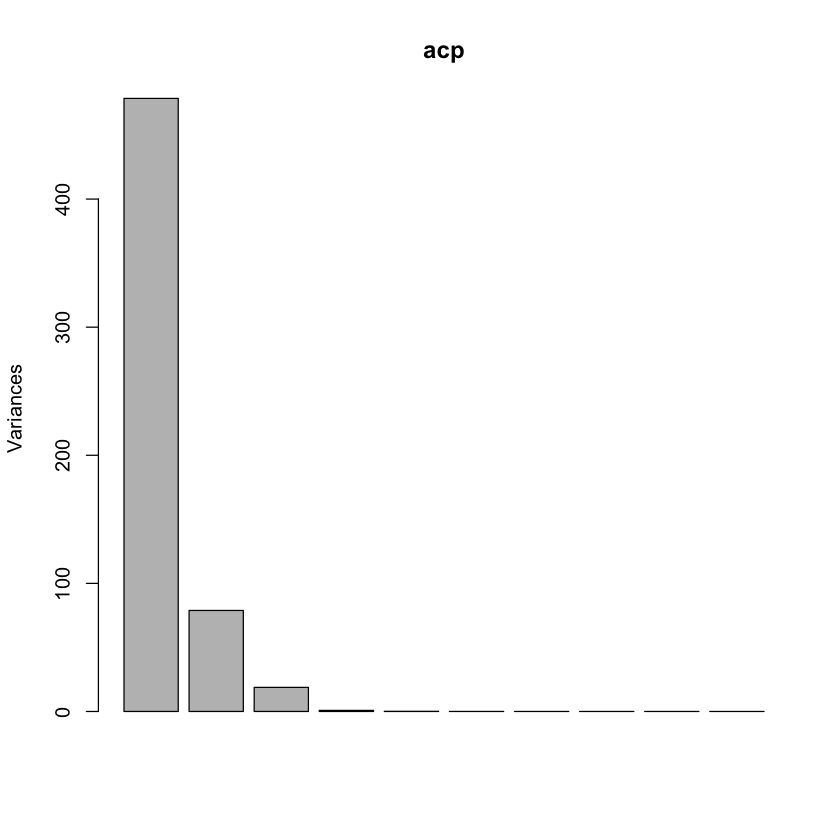

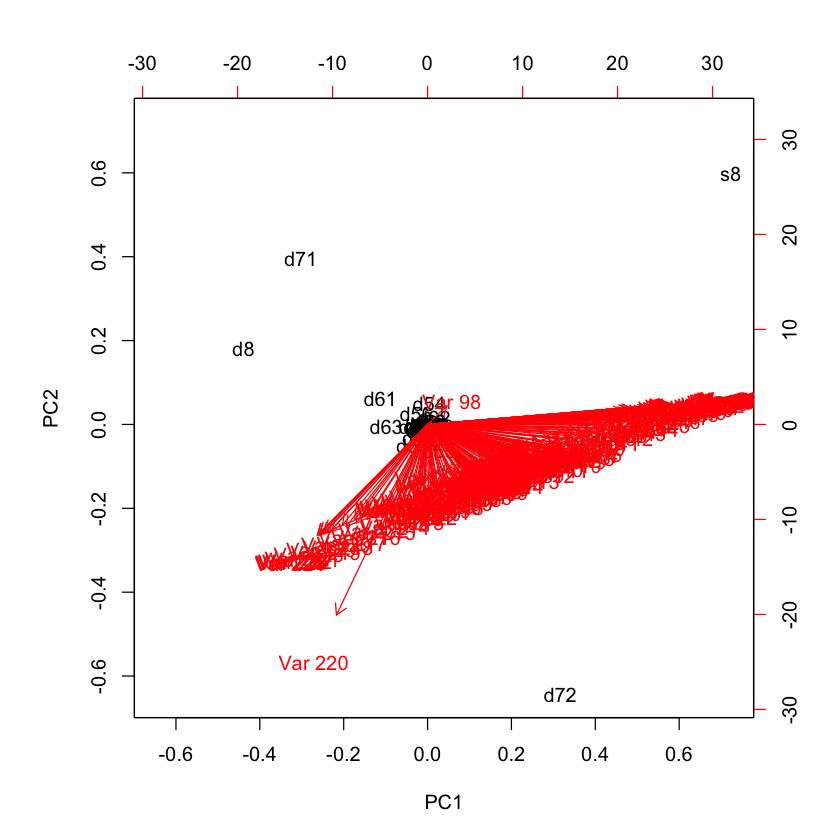

In [15]:
acp=prcomp(t(set5))
plot(acp)
biplot(acp)

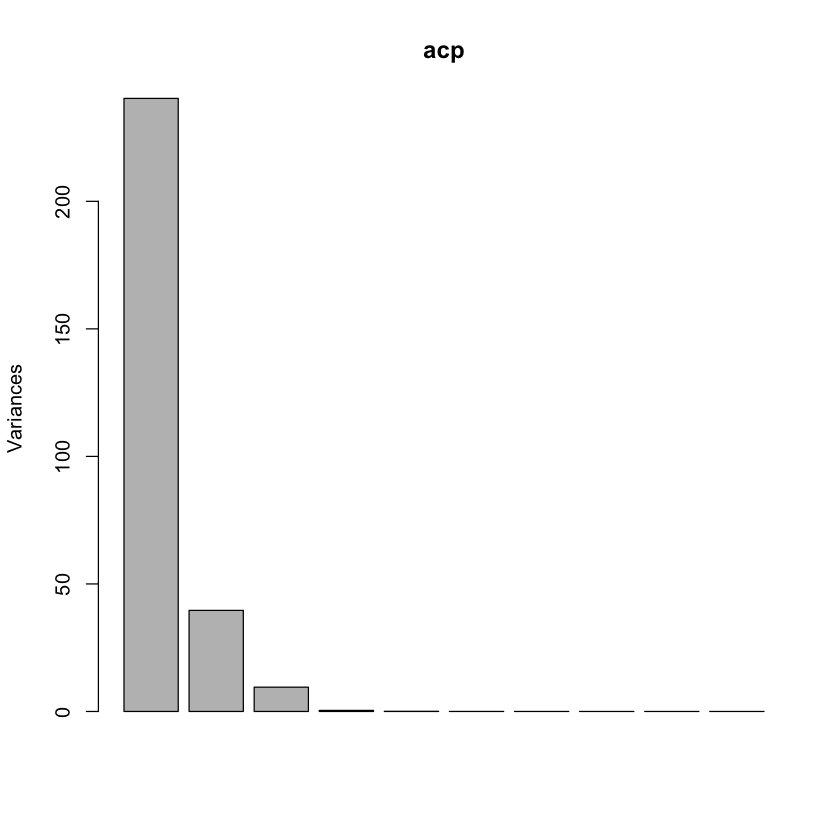

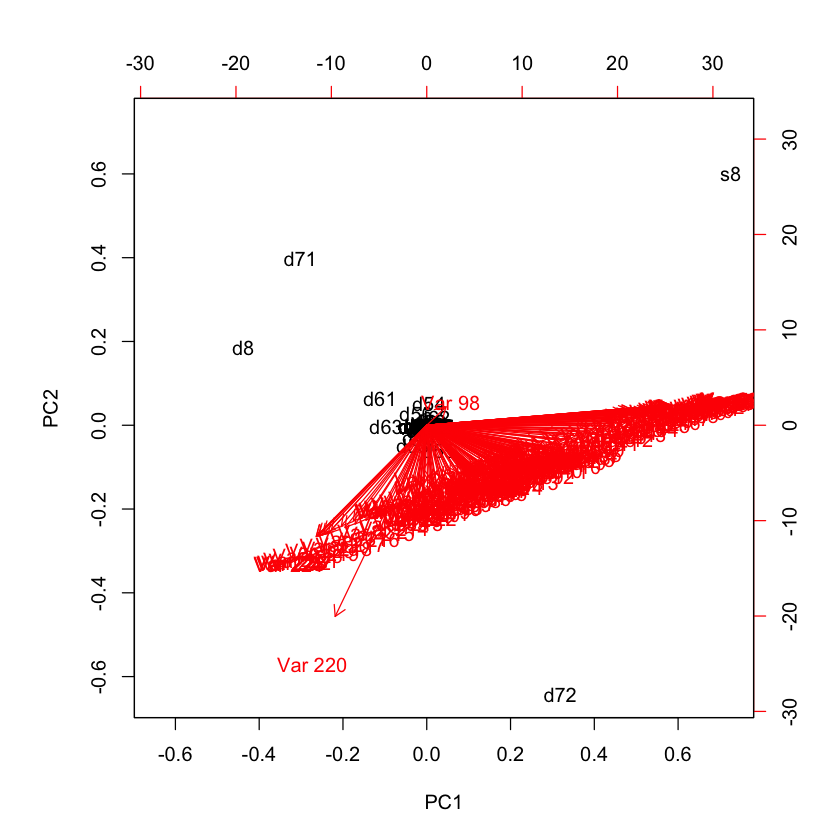

In [16]:
acp=prcomp(t(set6))
plot(acp)
biplot(acp)

## 4 Détection d'anomalies par différentes méthodes
### 4.1 Classification ascendante hierarchique 
#### Données sans anomalies

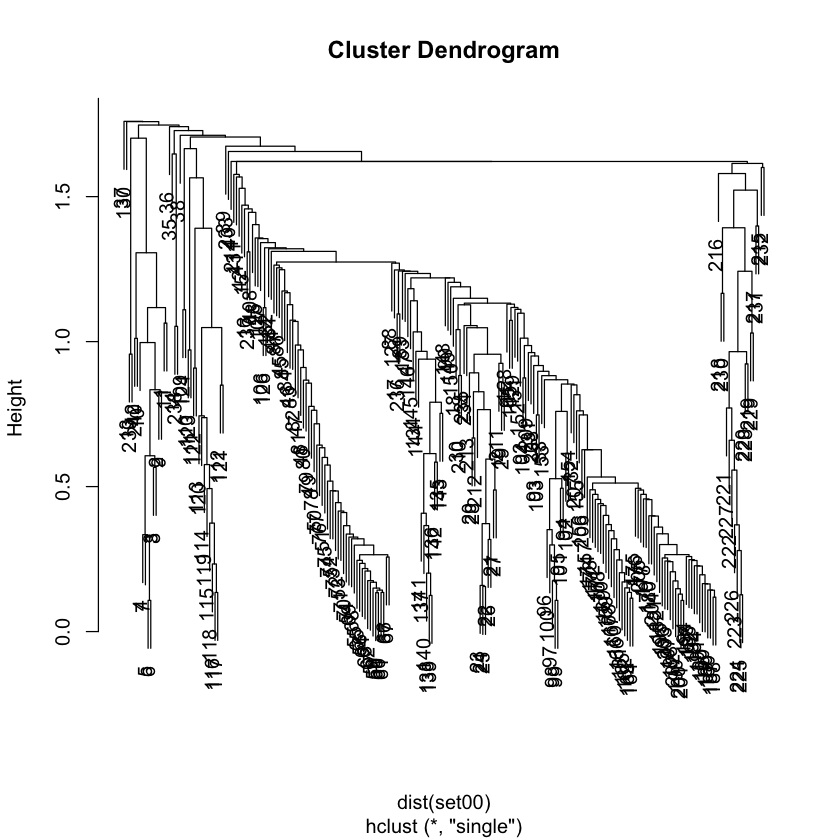

In [17]:
H = hclust(d = dist(set00), method = "single")
plot(H)

In [18]:
c = cutree(H, k = 5)
table(c, anomalies0)

   anomalies0
c     0
  1  15
  2 222
  3   1
  4   1
  5   1

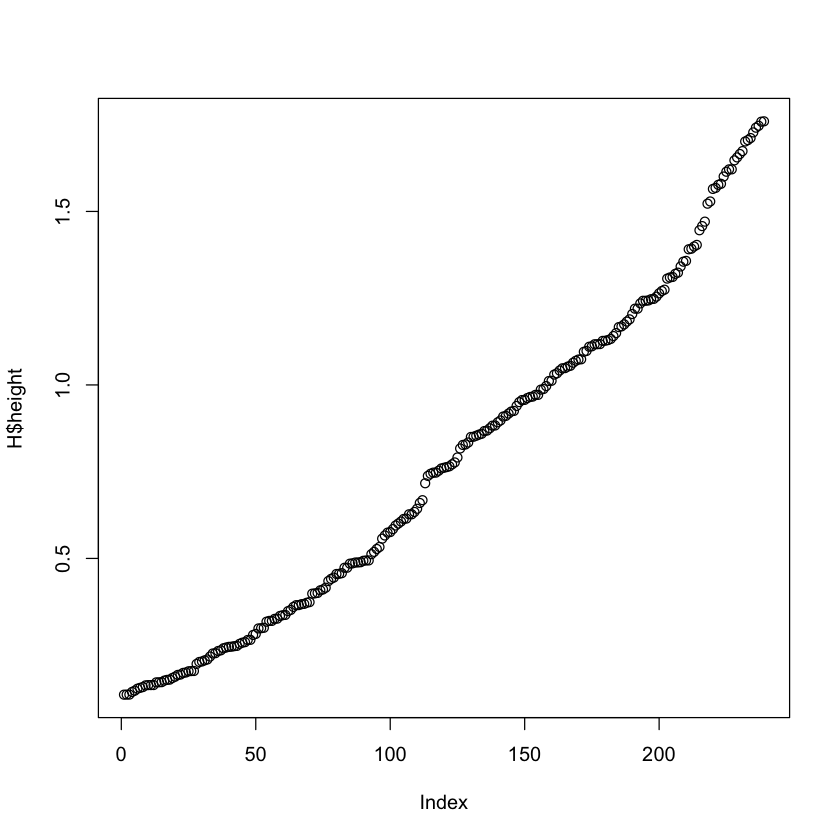

In [19]:
plot(H$height)

#### CAH sur données brutes

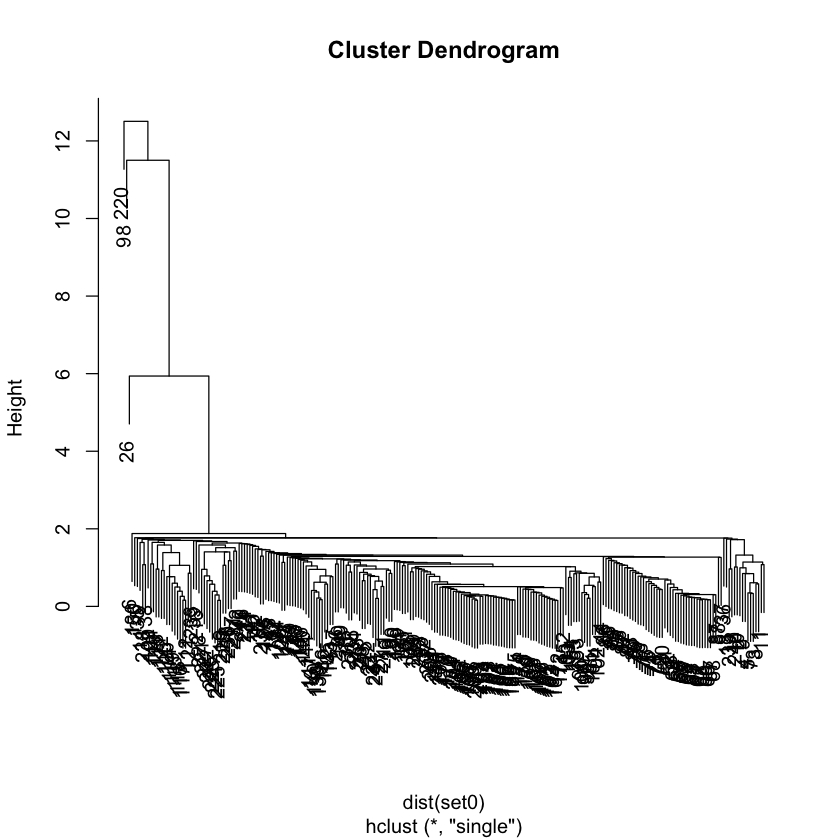

In [20]:
H0 = hclust(d = dist(set0), method = "single")
plot(H0)

In [21]:
c0 = cutree(H0, k = 5)
table(c0, anomalies)

   anomalies
c0    0   1
  1 232   4
  2   0   1
  3   0   1
  4   0   1
  5   0   1

In [22]:
H0$order

[1] 220  98  26   6 130 156  35  14 238  38 109 124 110 123 111 122 113 120
 [19] 114 119 115 118 116 117 112 121 233  39 216 228 221 227 222 226 223 224
 [37] 225 219 229 218 230 217 231 232  40 215 214 131  41  15  42  16 237 108
 [55] 125  43 107 132  34 106 126 127 134  89 133 148 147 146 145 144 141 137
 [73] 140 138 139 136 142 135 143  17 236  90 149  18  30 210 235 234 213  20
 [91]  28  25 212  22  23  24  21  27 211  19  29 150 128 129  91 105 151  92
[109] 104 209  31 208  33  32 207 206 201 157 176 205 177 178 179 180 204 181
[127] 182 195 196 197 198 199 200 202 203 183 194 193 192 184 191 185 190 186
[145] 187 188 189 175 174 171 158 170 159 169 168 167 160 166 161 165 162 163
[163] 164 172 173 152  93 103 154 155 153  96 100  97  99  95 101  94 102  44
[181]  86  85  45  84  70  83  46  82  47  81  48  80  79  49  78  77  76  75
[199]  74  73  71  72  50  51  52  53  69  54  55  66  65  56  64  63  57  61
[217]  62  58  59  60  67  68  87  88  37  36  13 239  12 240  10   2   9   4
[235]   5   7   3   8   1  11

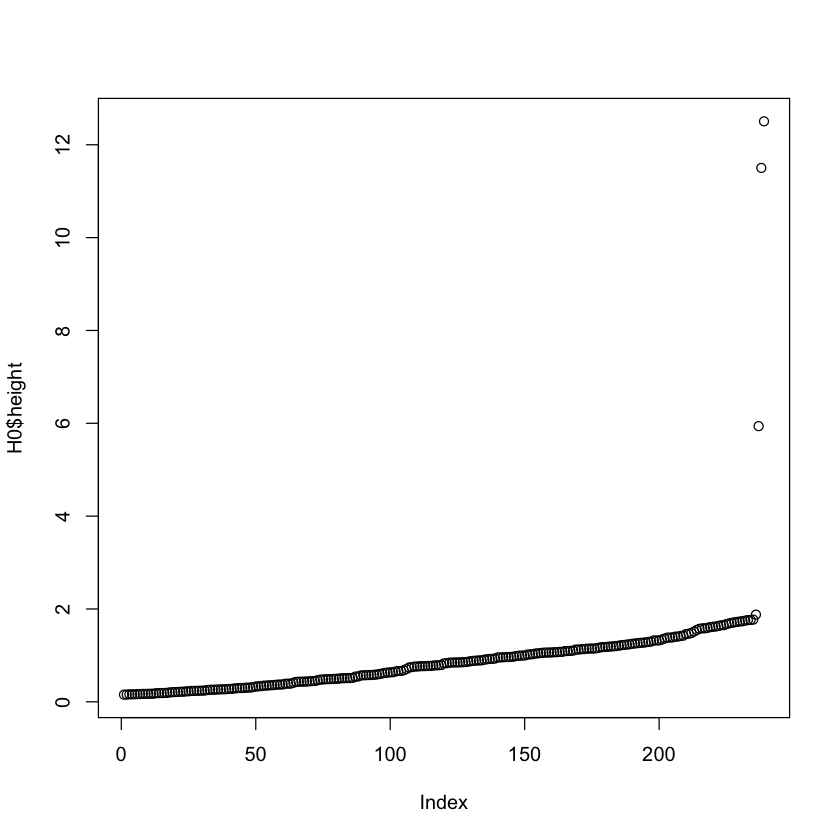

In [23]:
plot(H0$height)

#### CAH sur composantes principales

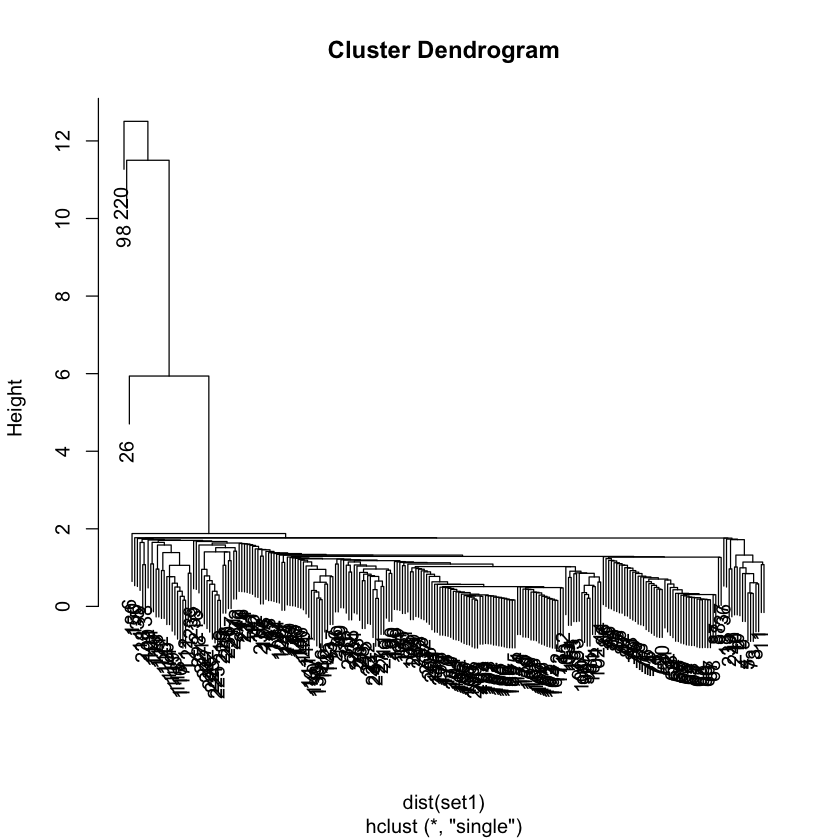

In [24]:
H1= hclust(d = dist(set1), method = "single")
plot(H1)

In [25]:
c1 = cutree(H1, k = 5)
table(c1, anomalies)

   anomalies
c1    0   1
  1 232   4
  2   0   1
  3   0   1
  4   0   1
  5   0   1

In [26]:
H1$order

[1] 220  98  26   6 130 156  35  14 238  38 109 124 110 123 111 122 113 120
 [19] 114 119 115 118 116 117 112 121 233  39 216 228 221 227 222 226 223 224
 [37] 225 219 229 218 230 217 231 232  40 215 214 131  41  15  42  16 237 108
 [55] 125  43 107 132  34 106 126 127 134  89 133 148 147 146 145 144 141 137
 [73] 140 138 139 136 142 135 143  17 236  90 149  18  30 210 235 234 213  20
 [91]  28  25 212  22  23  24  21  27 211  19  29 150 128 129  91 105 151  92
[109] 104 209  31 208  33  32 207 206 201 157 176 205 177 178 179 180 204 181
[127] 182 195 196 197 198 199 200 202 203 183 194 193 192 184 191 185 190 186
[145] 187 188 189 175 174 171 158 170 159 169 168 167 160 166 161 165 162 163
[163] 164 172 173 152  93 103 154 155 153  96 100  97  99  95 101  94 102  44
[181]  86  85  45  84  70  83  46  82  47  81  48  80  79  49  78  77  76  75
[199]  74  73  71  72  50  51  52  53  69  54  55  66  65  56  64  63  57  61
[217]  62  58  59  60  67  68  87  88  37  36  13 239  12 240  10   2   9   4
[235]   5   7   3   8   1  11

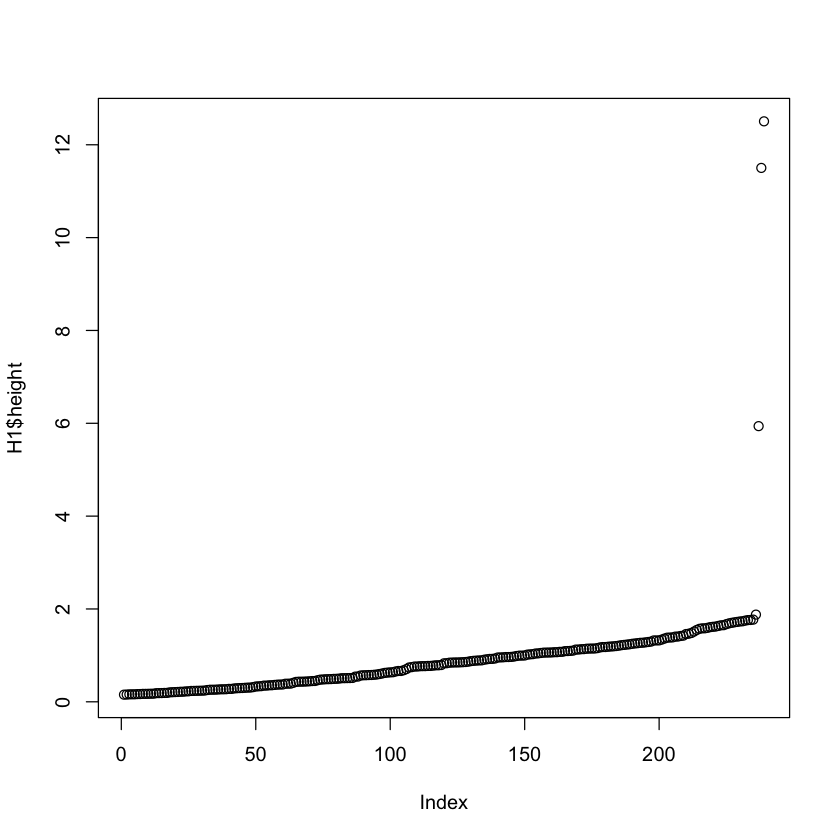

In [27]:
plot(H1$height)

#### CAH sur les premières composantes principales

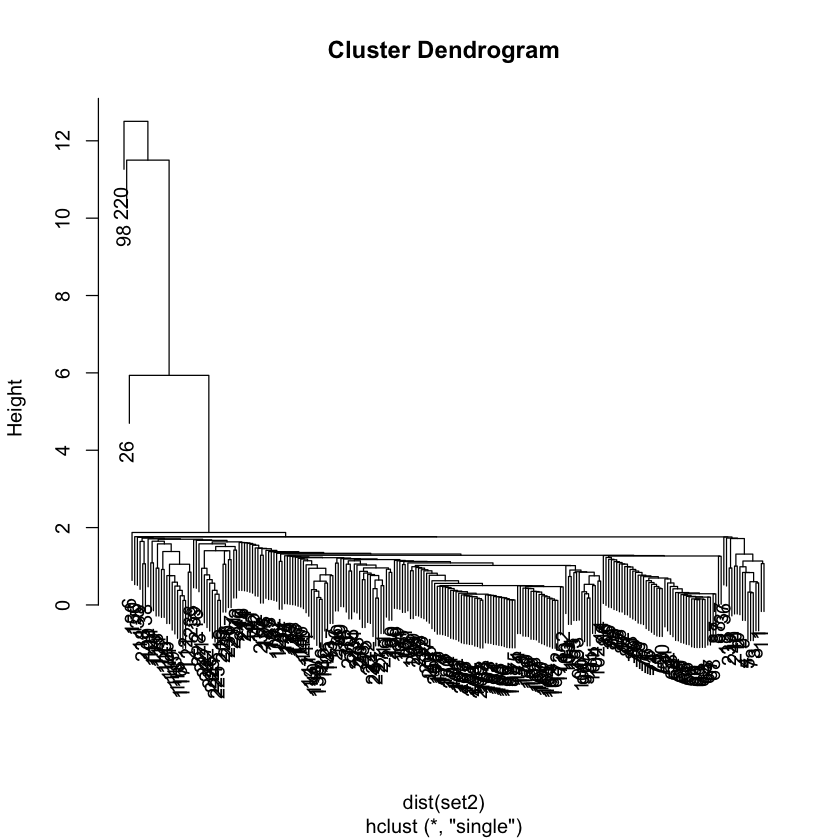

In [28]:
H2 = hclust(d = dist(set2), method = "single")
plot(H2)

In [29]:
c2 = cutree(H2, k = 5)
table(c2, anomalies)

   anomalies
c2    0   1
  1 232   4
  2   0   1
  3   0   1
  4   0   1
  5   0   1

[1] 220  98  26   6 130 156  35  14 238  38 109 124 110 123 111 122 113 120
 [19] 114 119 115 118 116 117 112 121 233  39 216 228 221 227 222 226 223 224
 [37] 225 219 229 218 230 217 231 232  40 215 214 131  41  15  42  16 237 108
 [55] 125  43 107 132 106 126  34 127 134  89 133 148 147 146 145 144 141 137
 [73] 140 138 139 136 142 135 143  17 236  90 149  18  30 210 235 234 213  20
 [91]  28  25 212  22  23  24  21  27 211  19  29 150 128 129  91 105 151  92
[109] 104 209  31 208  33  32 207 206 157 205 176 177 178 179 180 204 181 182
[127] 195 203 196 197 202 201 198 199 200 183 194 193 192 184 191 185 190 186
[145] 189 187 188 175 174 171 158 170 159 169 168 167 160 166 161 165 164 162
[163] 163 172 173 152  93 103 154 155 153  96 100  97  99  95 101  94 102  44
[181]  86  85  45  84  70  83  46  82  47  81  48  80  79  49  78  77  76  75
[199]  74  73  71  72  50  51  52  53  69  54  55  66  65  56  57  58  59  60
[217]  61  62  63  64  67  68  87  88  37  36  13 239  12 240  10   2   9   4
[235]   5   7   3   8   1  11

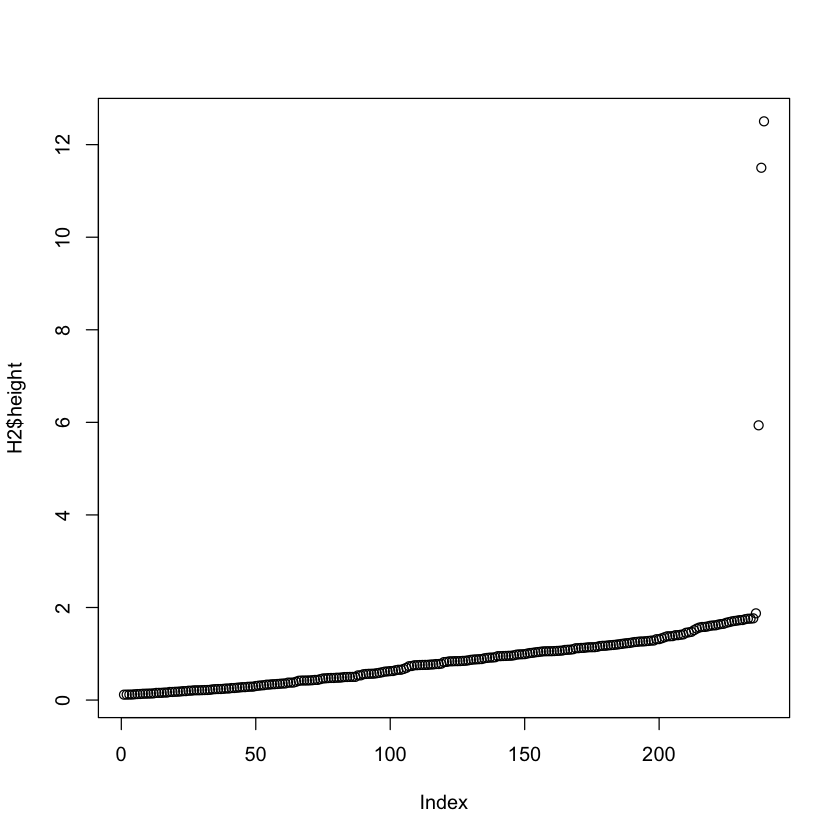

In [30]:
H2$order
plot(H2$height)

#### CAH sur les  coefficients d'ondelettes

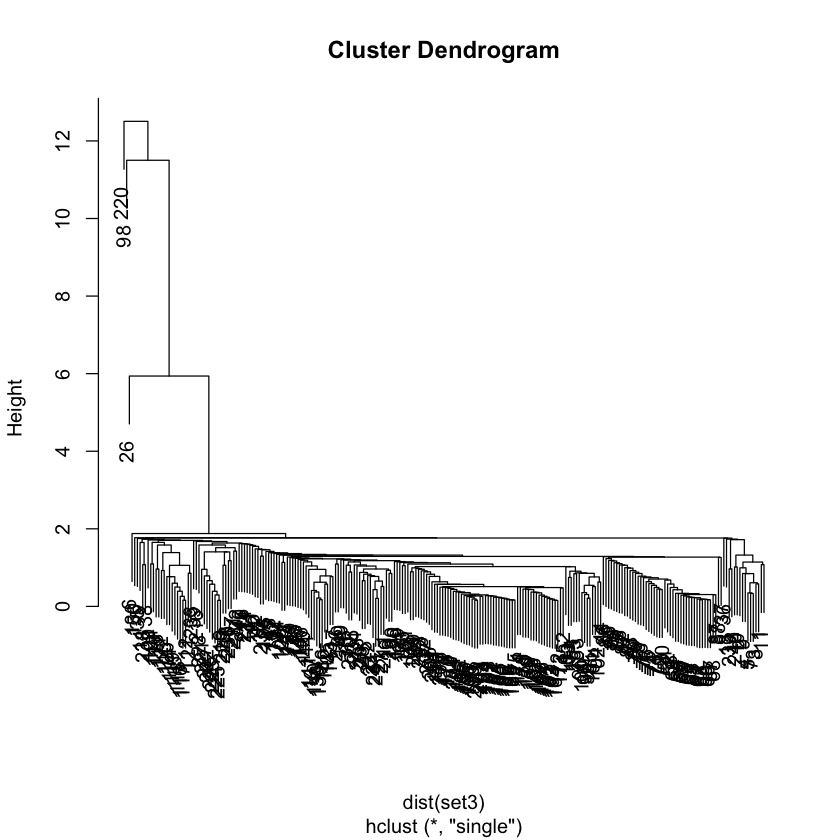

In [31]:
H3 = hclust(d = dist(set3), method = "single")
plot(H3)

In [32]:
c3 = cutree(H3, k = 5)
table(c3, anomalies)

   anomalies
c3    0   1
  1 232   4
  2   0   1
  3   0   1
  4   0   1
  5   0   1

In [33]:
H3$order

[1] 220  98  26   6 130 156  35  14 238  38 109 124 110 123 111 122 113 120
 [19] 114 119 115 118 116 117 112 121 233  39 216 228 221 227 222 226 223 224
 [37] 225 219 229 218 230 217 231 232  40 215 214 131  41  15  42  16 237 108
 [55] 125  43 107 132  34 106 126 127 134  89 133 148 147 146 145 144 141 137
 [73] 140 138 139 136 142 135 143  17 236  90 149  18  30 210 235 234 213  20
 [91]  28  25 212  22  23  24  21  27 211  19  29 150 128 129  91 105 151  92
[109] 104 209  31 208  33  32 207 206 201 157 176 205 177 178 179 180 204 181
[127] 182 195 196 197 198 199 200 202 203 183 194 193 192 184 191 185 190 186
[145] 187 188 189 175 174 171 158 170 159 169 168 167 160 166 161 165 162 163
[163] 164 172 173 152  93 103 154 155 153  96 100  97  99  95 101  94 102  44
[181]  86  85  45  84  70  83  46  82  47  81  48  80  79  49  78  77  76  75
[199]  74  73  71  72  50  51  52  53  69  54  55  66  65  56  64  63  57  61
[217]  62  58  59  60  67  68  87  88  37  36  13 239  12 240  10   2   9   4
[235]   5   7   3   8   1  11

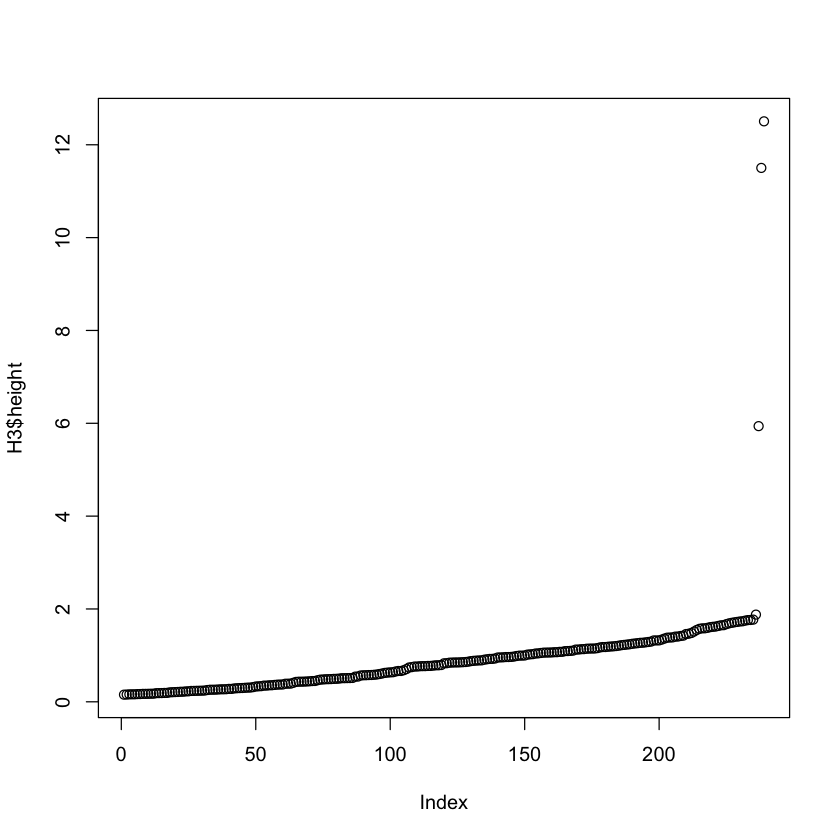

In [34]:
plot(H3$height)

#### CAH sur  les  coefficients d'ondelettes de niveau le plus fin

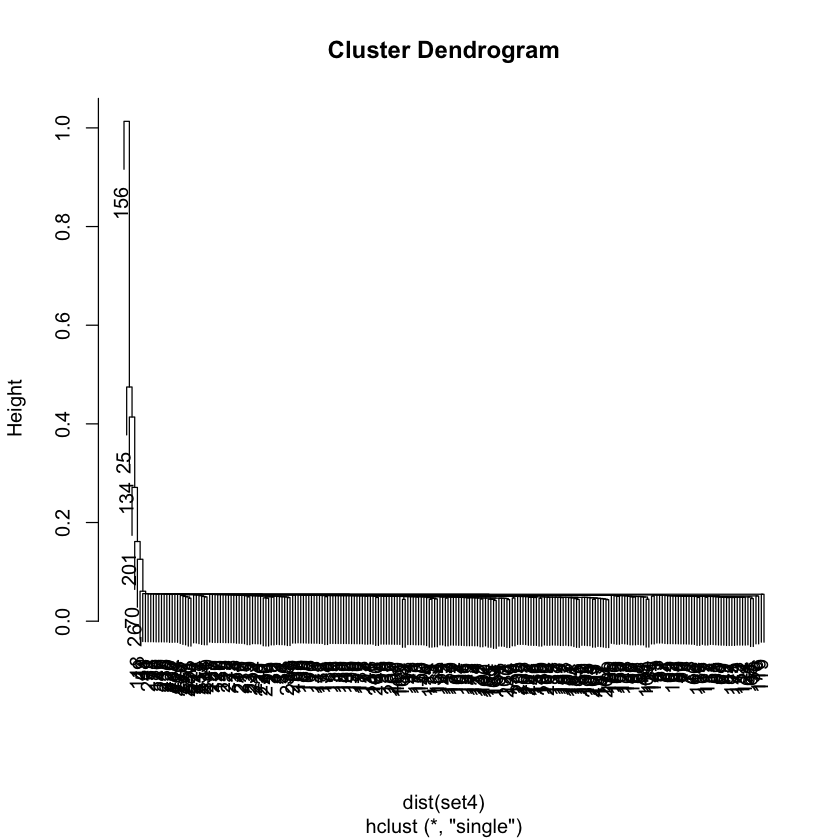

In [35]:
H4 = hclust(d = dist(set4), method = "single")
plot(H4)

In [36]:
c4 = cutree(H4, k = 5)
table(c4, anomalies)

   anomalies
c4    0   1
  1 231   5
  2   1   0
  3   0   1
  4   0   1
  5   0   1

In [37]:
H4$order

[1] 156  25 134 201  70  26 118  49  58  41 231  72  85 126  47 219 235 225
 [19] 226 232 224 223 229 227 228 230 221 222 218 233 217 234 240 123 237  20
 [37]  27 110 215  23 212  75  33  34 213 210  17  35 239 211 214  21 236  28
 [55] 216  24  29  32  19  22  31  30 238  18 209  87 168  89 139  90 105  10
 [73]  13 171  12 152 178 188   2 158  39  15 151 140  92 145  99 170   6 182
 [91] 175 177  44  36 141 206 144  98   9  38 180 202 101 160 162 165   8  94
[109]  45  11 176 153 150  40   4 179   3 133 166 164   5  42 157 130 172 167
[127] 104  97  96 159  43 173 174 131 132 102 100 161 155 169 154  95   7 103
[145] 220  16 138   1 205 200 135 192 207 143 146 136 148 189 196 208  14 183
[163] 137  37 149 198 193 197 181 184 185 186 142 190 195 194 203 199 187 191
[181] 147 204 129  93 106 163  50 127 128 108  46 107  86  88  91  48 109 120
[199] 121 115  63  51  77  84  64  69 122  54  80  60  78  71  73  68  66 114
[217]  56  67 117 112  57  53  83  59  61  79  82  81 125  74 113  52 111 124
[235]  62  65  55  76 116 119

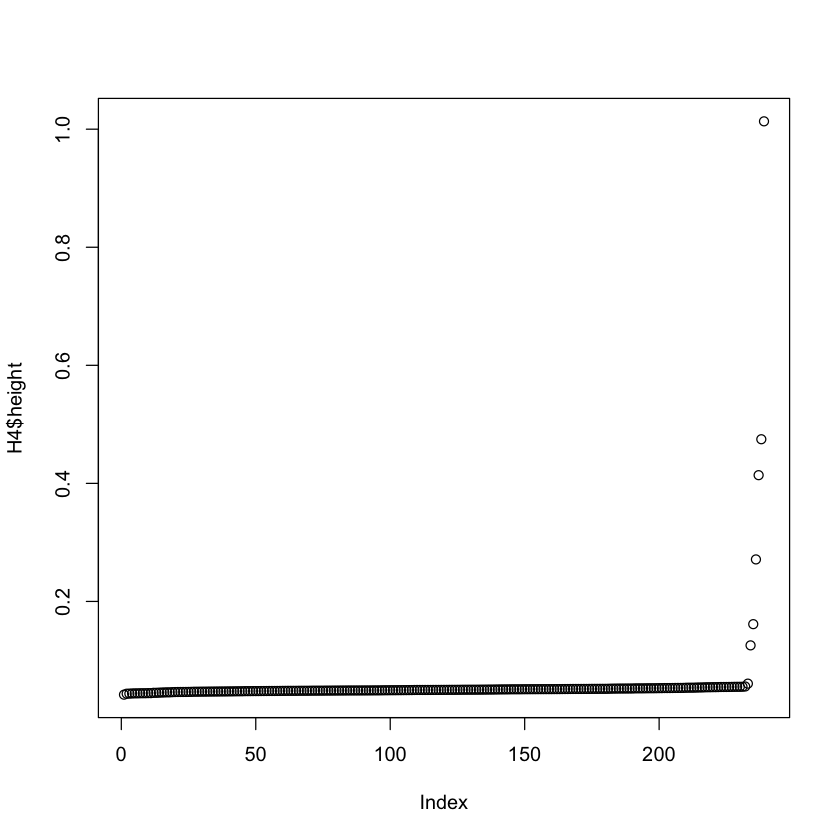

In [38]:
plot(H4$height)

#### Fausse alarme

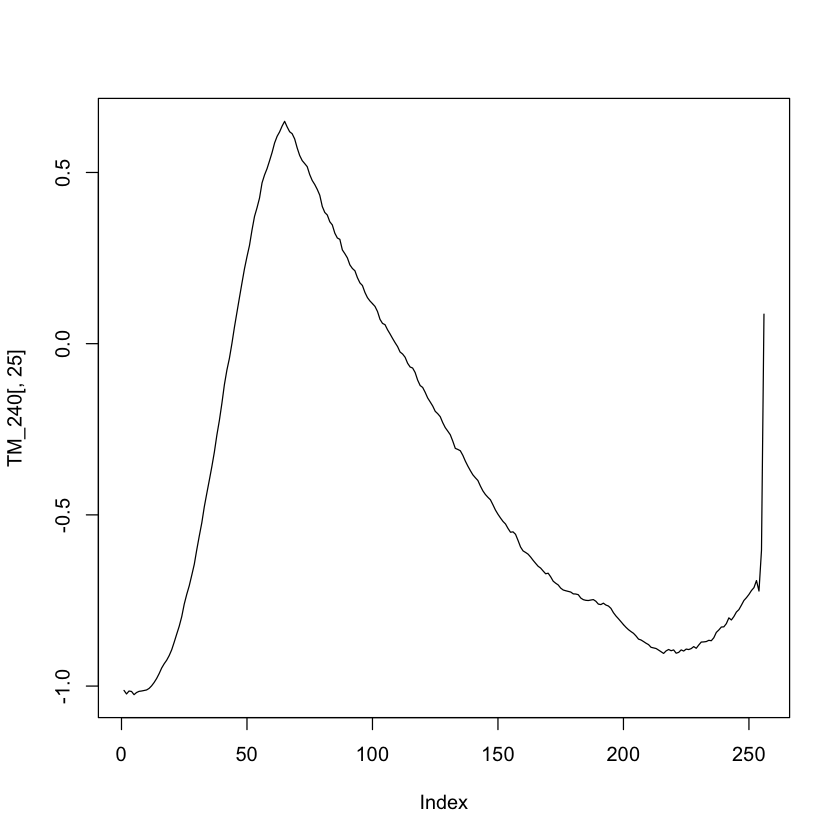

In [39]:
plot(TM_240[,25],type="l",col=color[25],lty=1)

#### CAH sur les  coefficients d'ondelettes de niveaux 0 à 6 

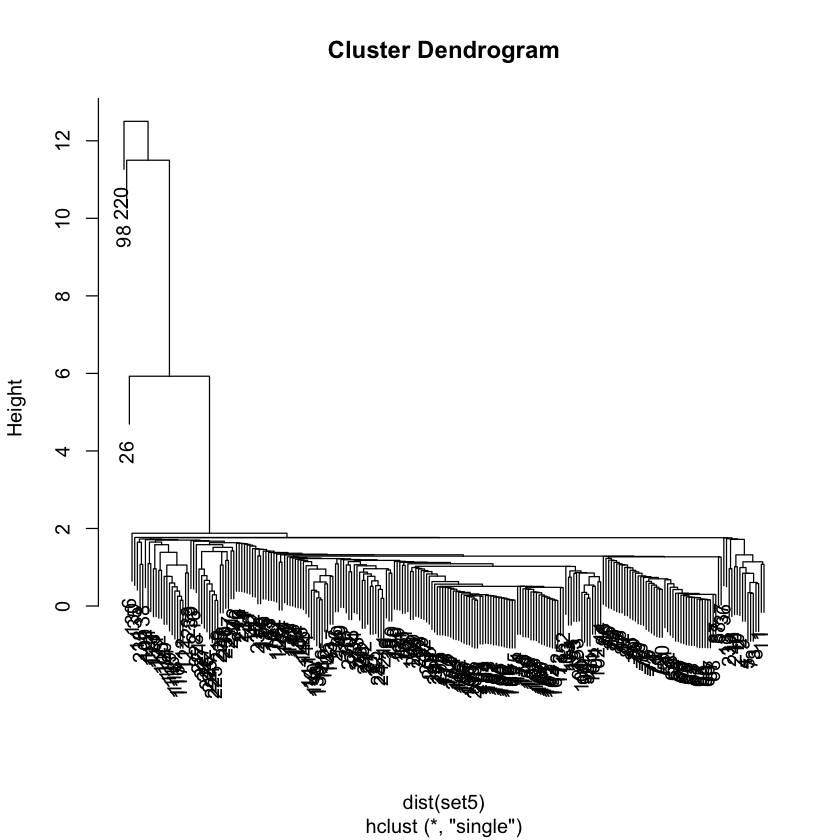

In [40]:
H5 = hclust(d = dist(set5), method = "single")
plot(H5)

In [41]:
c5 = cutree(H5, k = 5)
table(c5, anomalies)

   anomalies
c5    0   1
  1 232   4
  2   0   1
  3   0   1
  4   0   1
  5   0   1

In [42]:
H5$order

[1] 220  98  26   6 130  35  14 238  38 109 124 110 123 111 122 113 120 114
 [19] 119 115 118 116 117 112 121 233  39 216 228 221 227 222 226 223 224 225
 [37] 219 229 218 230 217 231 232  40 215 214 131  41  15  42  16 237 156 108
 [55] 125  43 107 132 106 126  34 127  89 133 148 147 134 146 145 144 141 137
 [73] 140 138 139 136 142 135 143  17 236  90 149  18  30 210 235 234 213  20
 [91]  28 212  21  27  25  22  23  24 211  19  29 150 128 129  91 105 151  92
[109] 104 209  31 208  33  32 207 206 157 201 176 205 177 178 179 180 204 181
[127] 182 195 196 197 198 199 200 202 203 183 194 193 192 184 191 185 190 186
[145] 187 188 189 175 174 171 158 170 159 169 168 167 160 166 161 165 162 163
[163] 164 172 173 152  93 103 154 155 153  96 100  97  99  95 101  94 102  44
[181]  86  85  45  84  70  83  46  82  47  81  48  80  79  49  78  77  76  75
[199]  74  73  71  72  50  51  52  53  69  54  55  66  65  56  64  63  57  61
[217]  62  58  59  60  67  68  87  88  37  36  13 239  12 240  10   2   9   4
[235]   5   7   3   8   1  11

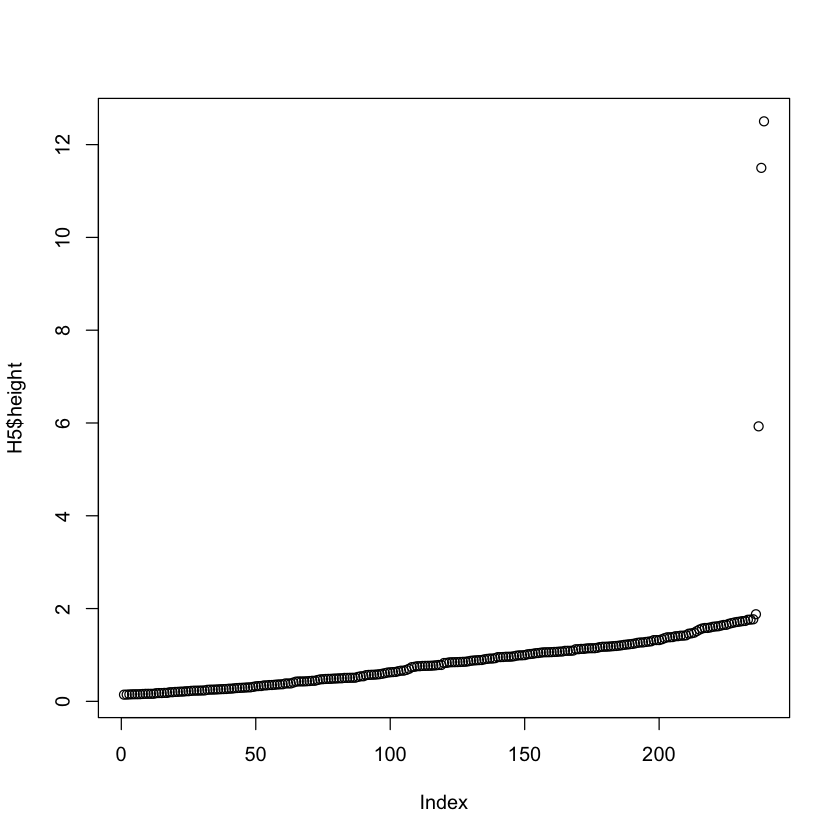

In [43]:
plot(H5$height)

#### CAH sur les  coefficients d'ondelettes  seuillés 

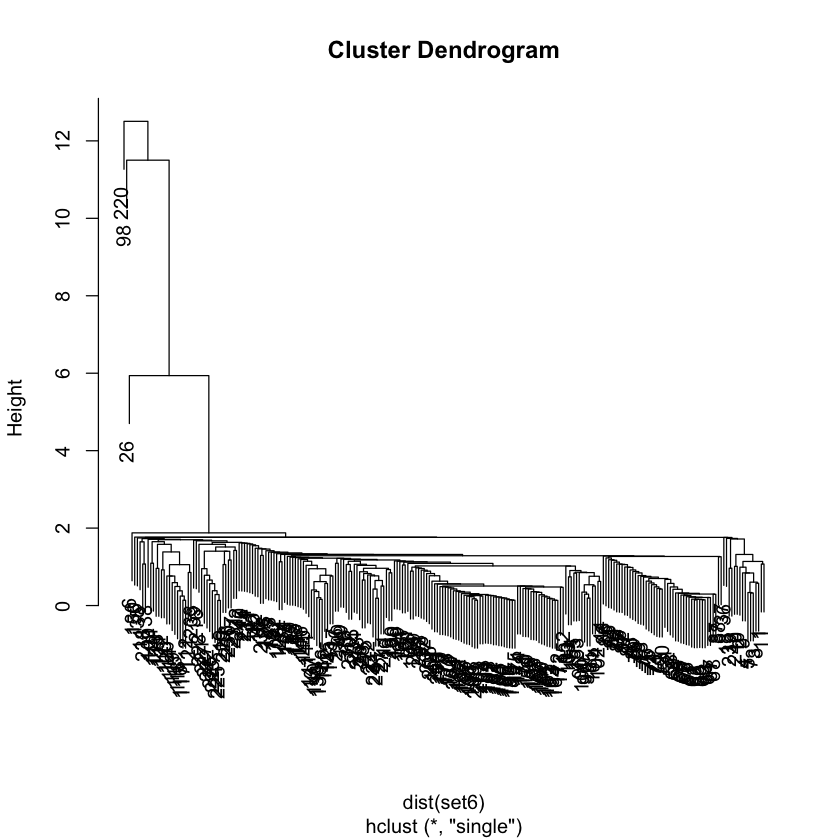

In [44]:
H6 = hclust(d = dist(set6), method = "single")
plot(H6)

In [45]:
c6 = cutree(H6, k = 5)
table(c6, anomalies)

   anomalies
c6    0   1
  1 232   4
  2   0   1
  3   0   1
  4   0   1
  5   0   1

In [46]:
H6$order

[1] 220  98  26   6 130 156  35  14 238  38 109 124 110 123 111 122 113 120
 [19] 114 119 115 118 116 117 112 121 233  39 216 228 221 227 222 226 223 224
 [37] 225 219 229 218 230 217 231 232  40 215 214 131  41  15  42  16 237 108
 [55] 125  43 107 132 106 126  34 127 134  89 133 148 147 146 145 144 141 137
 [73] 140 138 139 136 142 135 143  17 236  90 149  18  30 210 235 234 213  20
 [91]  28  25 212  22  23  24  21  27 211  19  29 150 128 129  91 105 151  92
[109] 104 209  31 208  33  32 207 206 157 201 205 176 177 178 179 180 204 181
[127] 182 195 196 197 198 199 200 202 203 183 194 193 192 184 191 185 190 186
[145] 187 188 189 175 174 171 158 170 159 169 168 167 160 166 161 165 162 163
[163] 164 172 173 152  93 103 154 155 153  96 100  97  99  95 101  94 102  44
[181]  86  85  45  84  70  83  46  82  47  81  48  80  79  49  78  77  76  75
[199]  74  73  71  72  50  51  52  53  69  54  55  66  65  56  57  61  62  58
[217]  59  60  63  64  67  68  87  88  37  36  13 239  12 240  10   2   9   4
[235]   5   7   3   8   1  11

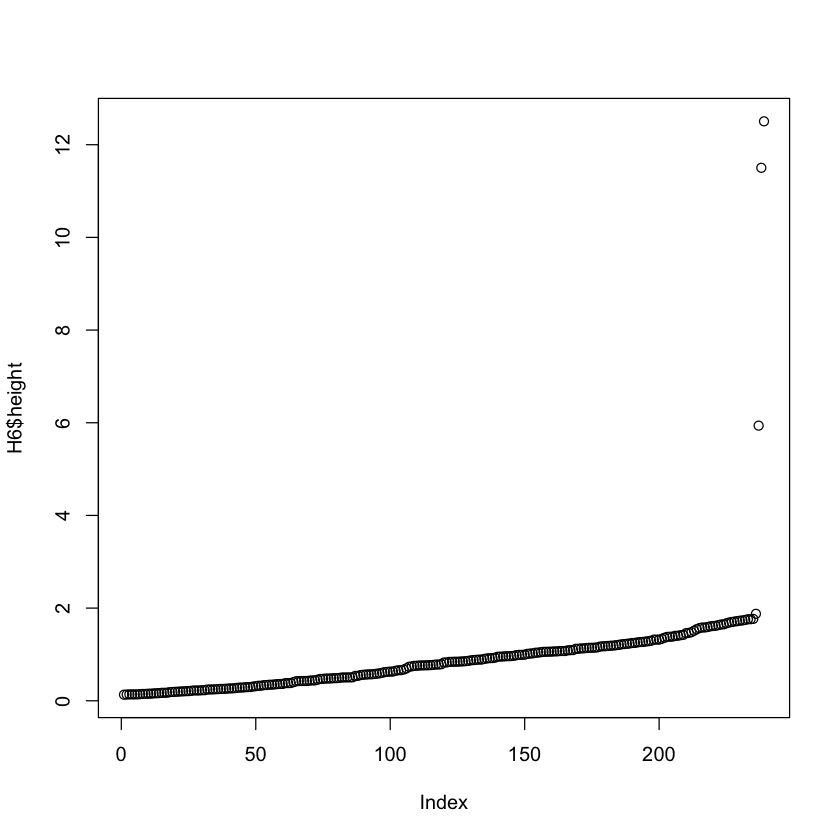

In [47]:
plot(H6$height)

** Q ** Comparer les résultats. Quelles jeux de features donnent des résultats comparables ? Lequel donne des résultats différents. Ceci est-il cohérent avec les types d'anomalies considérées ? 

### 4.2 One Class SVM
#### Avec les coefficients dans la base des composantes principales

In [48]:
ocsvm.acp = svm(set2, nu=0.05)
resu.svm.acp= ocsvm.acp$fitted
table(resu.svm.acp, anomalies)

            anomalies
resu.svm.acp   0   1
       FALSE   5   7
       TRUE  227   1

In [49]:
which(resu.svm.acp=="FALSE")

5   6  25  26  55  70  98 121 134 140 156 220 
  5   6  25  26  55  70  98 121 134 140 156 220

** Q. ** Commenter les résultats et tracer les courbes présentant des anomalies qui sont détectées et celles qui ne le sont pas, ainsi que les fausses alarmes. 

#### Avec les coefficients d'ondelettes de niveau le plus fin

In [50]:
ocsvm.ond7 = svm(set4, nu=0.05)
resu.svm.ond7= ocsvm.ond7$fitted
table(resu.svm.ond7, anomalies)

             anomalies
resu.svm.ond7   0   1
        FALSE  29   5
        TRUE  203   3

In [51]:
which(resu.svm.ond7=="FALSE")

8  17  20  25  26  27  38  41  49  58  66  70  84  89  99 101 110 119 121 122 
  8  17  20  25  26  27  38  41  49  58  66  70  84  89  99 101 110 119 121 122 
126 134 138 156 160 162 166 201 217 223 228 235 237 240 
126 134 138 156 160 162 166 201 217 223 228 235 237 240

#### Avec les coefficients d'ondelettes de niveau 0 à 6

In [52]:
ocsvm.ond = svm(set5, nu=0.05)
resu.svm.ond= ocsvm.ond$fitted
table(resu.svm.ond, anomalies)

            anomalies
resu.svm.ond   0   1
       FALSE  32   5
       TRUE  200   3

In [53]:
which(resu.svm.ond=="FALSE")

3   5  25  38  48  55  56  58  60  63  65  70  73  78  82  98 103 107 116 118 
  3   5  25  38  48  55  56  58  60  63  65  70  73  78  82  98 103 107 116 118 
120 122 123 129 134 135 138 139 142 146 156 201 221 225 227 229 240 
120 122 123 129 134 135 138 139 142 146 156 201 221 225 227 229 240

** Q. ** Commenter les résultats obtenus avec les coefficients d'ondelettes et retrouvez quelles sont les courbes atypiques qui sont détectées ainsi que les "faux positifs". 

### 4.3 Local Outlier Factor
#### Avec les coefficients dans la base des composantes principales

In [54]:
library(DMwR)
lof.acp1 = lofactor(data = set1, k = 5)
resu.lof.acp1= (lof.acp1>2)
table(resu.lof.acp1, anomalies)

             anomalies
resu.lof.acp1   0   1
        FALSE 231   5
        TRUE    1   3

In [55]:
lof.acp2 = lofactor(data = set2, k = 5)
resu.lof.acp2= (lof.acp2>2)
table(resu.lof.acp2, anomalies)

             anomalies
resu.lof.acp2   0   1
        FALSE 231   5
        TRUE    1   3

#### Avec les données brutes 

In [56]:
lof.acp0 = lofactor(data = set0, k = 5)
resu.lof.acp0= (lof.acp0>2)
table(resu.lof.acp0, anomalies)

             anomalies
resu.lof.acp0   0   1
        FALSE 231   5
        TRUE    1   3

** Q. ** Commenter ces résultats et retrouvez quelles sont les courbes atypiques qui sont détectées ainsi que les "faux positifs"

#### Avec les coefficients d'ondelettes

In [57]:
# Tous les coefficients
lof.ond = lofactor(data = set3, k =5)
resu.lof.ond= (lof.ond>2)
table(resu.lof.ond, anomalies)

            anomalies
resu.lof.ond   0   1
       FALSE 231   5
       TRUE    1   3

In [58]:
# Niveau le plus fin
lof.ond7 = lofactor(data = set4, k = 5)
resu.lof.ond7= (lof.ond7>2)
table(resu.lof.ond7, anomalies)

             anomalies
resu.lof.ond7   0   1
        FALSE 231   3
        TRUE    1   5

In [59]:
# Niveau 0 à 6 
lof.ond06 = lofactor(data = set5, k = 5)
resu.lof.ond06= (lof.ond06>2)
table(resu.lof.ond06, anomalies)

              anomalies
resu.lof.ond06   0   1
         FALSE 231   5
         TRUE    1   3

In [60]:
# Coefficients seuillés
lof.ondthresh = lofactor(data = set6, k = 5)
resu.lof.ondthresh= (lof.ondthresh>2)
table(resu.lof.ondthresh, anomalies)

                  anomalies
resu.lof.ondthresh   0   1
             FALSE 231   5
             TRUE    1   3

## 5 Visualisation des résultats

## 5.1 Une fonction pour visualiser les résultats

In [61]:
plot.LOF= function(Vec, main ="Log(Local Outlier Factor)", lim = c(4), ymax = max(Vec)){
  plot(Vec, xlab = "Days", ylab = "log(Local Outlier Factor)", main = main, ylim = c(0, ymax), 
       pch = 1+ 1*(Vec > min(lim)))
  anom = which(color!="1")
  for(i in anom){
    abline(v = i, col = color[i], lty = 2)
  }
  points (anom, Vec[anom], col = 2 + 5*(Vec[anom]>min(lim)) - 4*(Vec[anom]>=max(lim)) ,cex = 2, pch = 16)
  points (anom, Vec[anom], col = 1 ,cex = 2, pch = 1)
  for(i in lim){
    abline(h=i, lwd = 2)
  }
  legend("topright", c("LOF", "Anom Detected","Anom not detected", "Pattern anom", "Periodicity anom", "Local Anom", "Limit"), lty = c(NA,NA,NA,2,2,2,1),pch = c(1,16,16,NA,NA,NA,NA), 
         lwd = c(1,1,1,1,1,1,2), col = c(1,3,2,2,"orange", "pink3", 1))
}

** Q. ** Commenter les résultats obtenus avec les coefficients d'ondelettes et retrouvez quelles sont les courbes atypiques qui sont détectées ainsi que les "faux positifs". Essayez de déterminer comment optimiser le choix du paramètre **k**. 

## 5.2 Résultats obtenus par  *One-Class-SVM* 

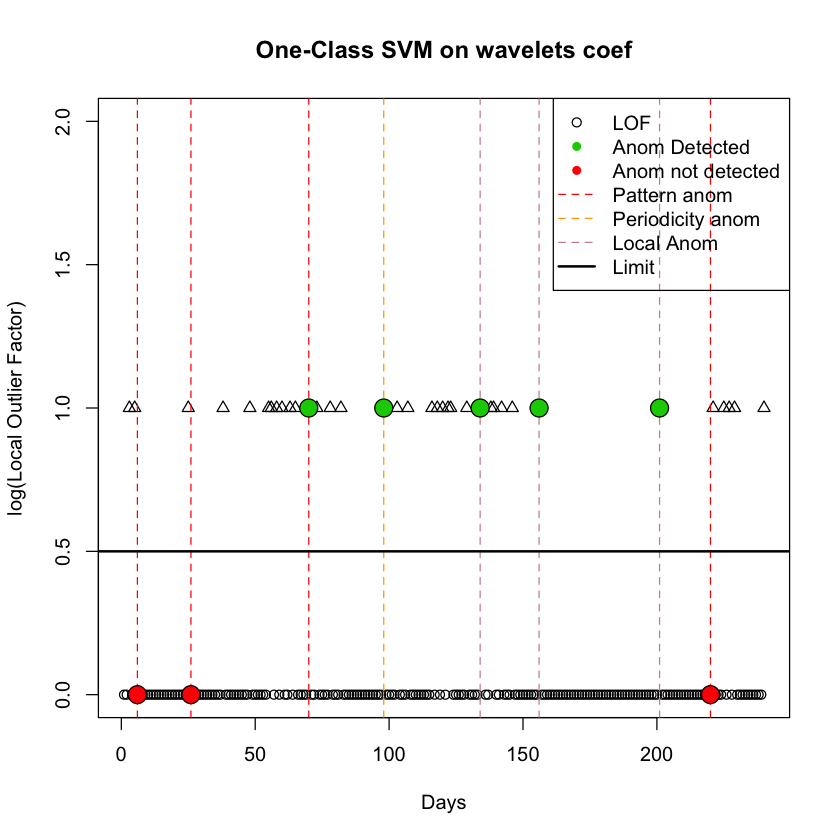

In [62]:
# OCSVM on wavelet coef : 
plot.LOF(1 - resu.svm.ond, ymax = 2, lim = 0.5, main ="One-Class SVM on wavelets coef")

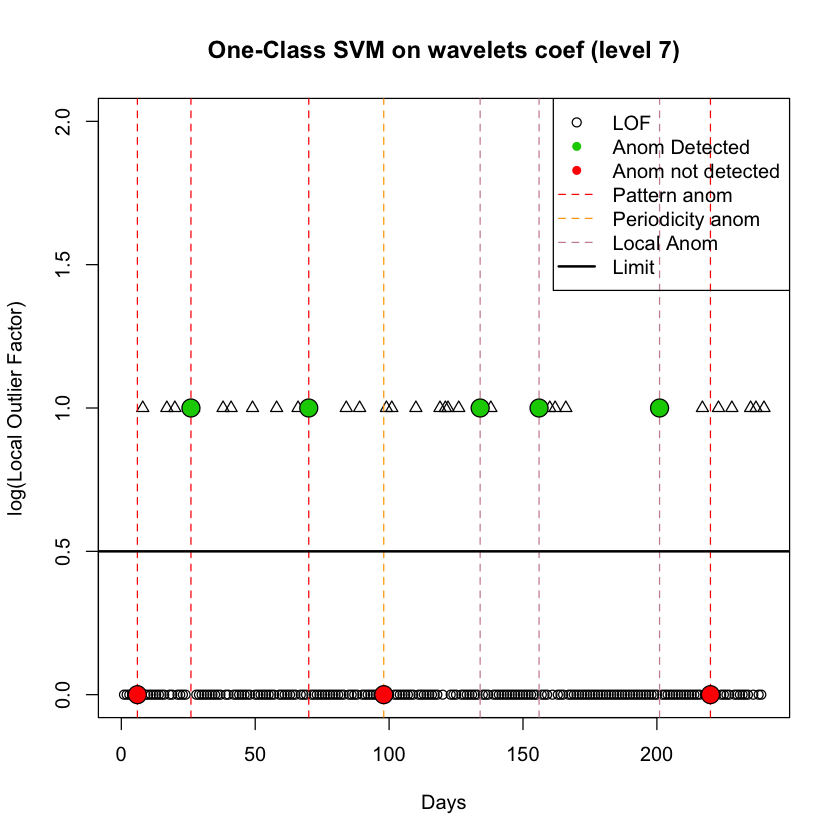

In [63]:
plot.LOF(1 - resu.svm.ond7, ymax = 2, lim = 0.5, main ="One-Class SVM on wavelets coef (level 7)")

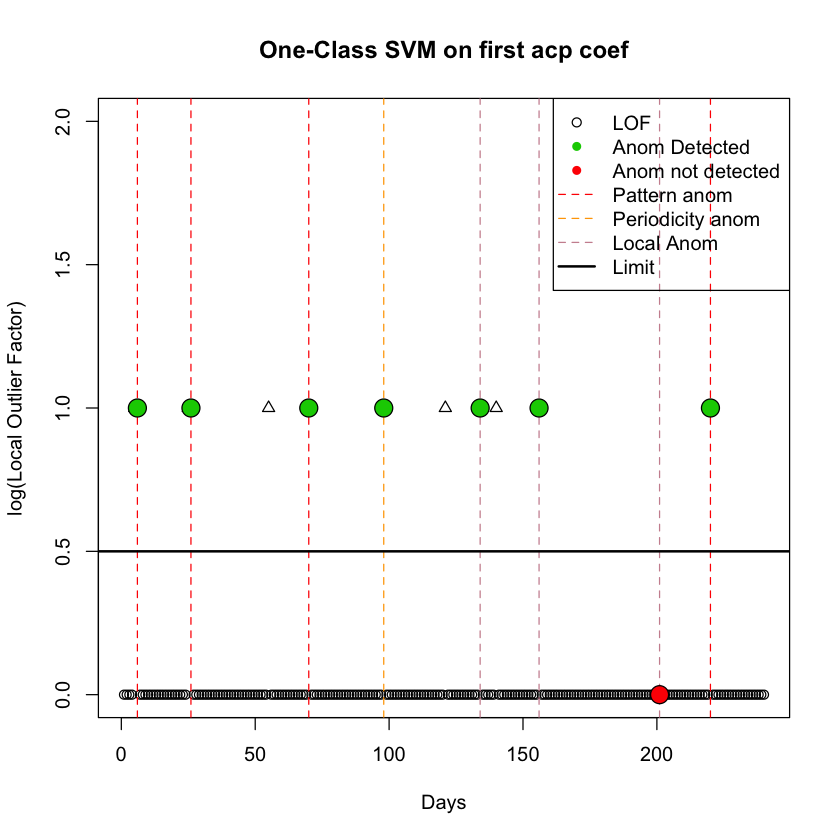

In [64]:
# Ce qui fonctionne le mieux : OCSVM on first ACP coef 
plot.LOF(1 - resu.svm.acp, ymax = 2, lim = 0.5, main ="One-Class SVM on first acp coef")

### 5.3 Résultats obtenus par  *Local Outlier Factor*: 

In [65]:
#LOF on  ACP coef
plot.LOF(lof.acp, ymax = 20, lim = 2, main = "LOF on ACP coef")

ERROR: Error in plot(Vec, xlab = "Days", ylab = "log(Local Outlier Factor)", : objet 'lof.acp' introuvable


In [ ]:
plot.LOF(lof.acp2, ymax = 20, lim = 2, main = "LOF on first ACP coef")

In [ ]:
#LOF on wavelet coef
plot.LOF(lof.ond, ymax = 20, lim = 2, main = " LOF on wavelets coef")

In [ ]:
plot.LOF(lof.ond7, ymax = 20, lim = 2, main = "LOF on wavelets coef (max level)")

**Q** Ajouter d'autres méthodes de détection d'anomalies